In [1]:
!pip install codecarbon

In [1]:
import networkx as nx
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
import sys

# Aumentar o limite de recursão para grafos grandes
sys.setrecursionlimit(200000)

# Fixar sementes globais para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

Versão Sem MinHeap

In [2]:
# --- Implementação Clássica (O(V^2 + E)) ---
# Copiado de dijsktra.ipynb

def dijkstra_classic(start, edges):
    numberOfVertices = len(edges)
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0
    visited = set()

    while len(visited) != numberOfVertices:
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)

        if currentMinDistance == float("inf"):
            break

        visited.add(vertex)

        for edge in edges[vertex]:
            destination, distanceToDestination = edge
            if destination in visited:
                continue

            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance

    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))


def getVertexWithMinDistance(distances, visited):
    currentMinDistance = float("inf")
    vertex = -1

    for vertexIdx, distance in enumerate(distances):
        if vertexIdx in visited:
            continue
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance

    return vertex, currentMinDistance

Versão com MinHeap

In [3]:
# --- Implementação Min-Heap (O((V + E) log V)) ---
# Copiado de dijsktra_min_heap.ipynb

class MinHeap:
    def __init__(self, array):
        self.vertexMap = {idx: idx for idx in range(len(array))}
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        return len(self.heap) == 0

    def buildHeap(self, array):
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        childOneIdx = currentIdx * 2 + 1
        while childOneIdx <= endIdx:
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap
                childOneIdx = currentIdx * 2 + 1
            else:
                return

    def siftUp(self, currentIdx, heap):
        parentIdx = (currentIdx - 1) // 2
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)
            currentIdx = parentIdx
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        if self.isEmpty():
            return None
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        self.vertexMap[heap[i][0]] = j
        self.vertexMap[heap[j][0]] = i
        heap[i], heap[j] = heap[j], heap[i]

    def update(self, vertex, value):
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        self.siftUp(self.vertexMap[vertex], self.heap)

def dijkstra_min_heap(start, edges):
    numberOfVertices = len(edges)
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0
    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)

    while not minDistancesHeap.isEmpty():
        vertex, currentMinDistance = minDistancesHeap.remove()
        if currentMinDistance == float("inf"):
            break
        for edge in edges[vertex]:
            destination, distanceToDestination = edge
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

Funções auxiliares


In [4]:
def generate_graph(n, p=0.1):
    """
    Gera um grafo aleatório ponderado e garante conectividade
    usando o componente gigante.
    """
    # 1. Gerar grafo
    G_raw = nx.gnp_random_graph(n, p, seed=random.randint(0, 100000))

    # 2. Garantir conectividade pegando o componente gigante
    if not nx.is_connected(G_raw):
        components = list(nx.connected_components(G_raw))
        if not components: # Grafo vazio
            return None
        largest_comp = max(components, key=len)
        G = G_raw.subgraph(largest_comp).copy()
    else:
        G = G_raw

    # 3. Renomear nós para garantir indexação de 0 a N-1
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    # 4. Adicionar pesos inteiros positivos (1 a 10)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, 10)

    return G

def convert_nx_to_adj_list(G):
    """
    Converte um grafo networkx para o formato de lista de adjacência
    esperado pelas suas funções.
    Formato: [ [[dest1, peso1], ...], [[dest2, peso2], ...], ... ]
    """
    num_nodes = G.number_of_nodes()
    adj_list = [[] for _ in range(num_nodes)]

    for u in G.nodes():
        for v, data in G[u].items():
            weight = data.get('weight', 1) # Pega o peso, default 1
            adj_list[u].append([v, weight])

    return adj_list

Loop Principal

In [ ]:
# --- Configuração do Experimento ---
#SIZES = [100, 500, 1000, 2500, 5000, 7500] # Comece menor para testar
SIZES = [100, 500, 1_000, 5_000, 10_000, 15_000] # Versão final
REPETITIONS = 15  # 15-20 repetições por tamanho
SOURCES_PER_REP = 5  # 5 nós de origem por repetição

# Lista para armazenar todos os resultados
import pandas as pd

try:
    df_existing = pd.read_csv("dijkstra_benchmark_partial.csv")
    all_results = df_existing.to_dict("records")
    print(f"Resultados anteriores carregados: {len(all_results)} linhas")
except FileNotFoundError:
    all_results = []
    print("Nenhum resultado anterior encontrado, começando do zero")


# --- Loop Principal ---
for size in SIZES:
    print(f"\n--- Iniciando testes para N = {size} ---")

    for rep in range(REPETITIONS):
        print(f"  Repetição {rep+1}/{REPETITIONS}...")

        # 1. Gerar grafo e converter
        G = generate_graph(size)
        if G is None or G.number_of_nodes() == 0:
            print(f"Falha ao gerar grafo para N={size}, pulando.")
            continue

        adj_list = convert_nx_to_adj_list(G)

        # 2. Escolher fontes aleatórias
        # Garantir que temos nós suficientes
        num_nodes_actual = G.number_of_nodes()
        if num_nodes_actual == 0:
            continue

        k = min(num_nodes_actual, SOURCES_PER_REP)
        sources = random.sample(list(G.nodes()), k)

        for source in sources:

            # --- Teste 1: Dijkstra Clássico ---
            tracker = EmissionsTracker(save_to_file=False, log_level="error")
            tracker.start()
            start_time = time.time()

            dijkstra_classic(source, adj_list)

            elapsed_time = time.time() - start_time
            emissions = tracker.stop() * 1000 # Convertendo kg para g

            all_results.append({
                "algoritmo": "Classic (V^2)",
                "size": num_nodes_actual,
                "repetition": rep,
                "source": source,
                "time_sec": elapsed_time,
                "co2_grams": emissions
            })

            # --- Teste 2: Dijkstra Min-Heap ---
            tracker = EmissionsTracker(save_to_file=False, log_level="error")
            tracker.start()
            start_time = time.time()

            dijkstra_min_heap(source, adj_list)

            elapsed_time = time.time() - start_time
            emissions = tracker.stop() * 1000 # Convertendo kg para g

            all_results.append({
                "algoritmo": "Min-Heap (E log V)",
                "size": num_nodes_actual,
                "repetition": rep,
                "source": source,
                "time_sec": elapsed_time,
                "co2_grams": emissions
            })

            # --- Teste 3: NetworkX (Referência) ---
            tracker = EmissionsTracker(save_to_file=False, log_level="error")
            tracker.start()
            start_time = time.time()

            nx.shortest_path_length(G, source=source, weight='weight')

            elapsed_time = time.time() - start_time
            emissions = tracker.stop() * 1000 # Convertendo kg para g

            all_results.append({
                "algoritmo": "NetworkX",
                "size": num_nodes_actual,
                "repetition": rep,
                "source": source,
                "time_sec": elapsed_time,
                "co2_grams": emissions
            })
    #Salvamento parcial ao final de cada size
    df_partial = pd.DataFrame(all_results)
    df_partial.to_csv("dijkstra_benchmark_partial.csv", index=False)
    print(f"Resultados parciais salvos após concluir N={size}")
print("--- Coleta de dados concluída! ---")

# Converter resultados para DataFrame
df_results = pd.DataFrame(all_results)
df_results.to_csv("dijkstra_benchmark_raw.csv", index=False)

Resultados anteriores carregados: 1125 linhas

--- Iniciando testes para N = 15000 ---
  Repetição 1/15...


[codecarbon WARNING @ 20:45:06] Multiple instances of codecarbon are allowed to run at the same time.


  Repetição 2/15...
  Repetição 3/15...
  Repetição 4/15...
  Repetição 5/15...
  Repetição 6/15...
  Repetição 7/15...
  Repetição 8/15...
  Repetição 9/15...
  Repetição 10/15...
  Repetição 11/15...
  Repetição 12/15...
  Repetição 13/15...
  Repetição 14/15...
  Repetição 15/15...
Resultados parciais salvos após concluir N=15000

--- Iniciando testes para N = 20000 ---
  Repetição 1/15...


Corretude

In [17]:
def validate_correctness(n=50, p=0.2):
    """
    Gera um grafo pequeno e compara os resultados
    do Dijkstra Clássico, Min-Heap e NetworkX.
    """
    # Gerar grafo e converter
    G_test = generate_graph(n, p)
    adj_list_test = convert_nx_to_adj_list(G_test)
    source = random.choice(list(G_test.nodes()))

    # Rodar os três algoritmos
    dist_classic = dijkstra_classic(source, adj_list_test)
    dist_heap = dijkstra_min_heap(source, adj_list_test)
    dist_nx = nx.single_source_dijkstra_path_length(G_test, source, weight='weight')
    dist_nx_list = [dist_nx.get(i, -1) for i in range(len(G_test))]

    # Comparar resultados
    print(f"Fonte escolhida: {source}")
    print("Classic == MinHeap:", dist_classic == dist_heap)
    print("Classic == NetworkX:", dist_classic == dist_nx_list)

    # Se quiser ver onde diverge
    for i, (c, h, nxv) in enumerate(zip(dist_classic, dist_heap, dist_nx_list)):
        if not (c == h == nxv):
            print(f"Divergência no nó {i}: Classic={c}, Heap={h}, NetworkX={nxv}")

# Executar teste
validate_correctness()


Fonte escolhida: 25
Classic == MinHeap: True
Classic == NetworkX: True


Plotagem

In [1]:
# 1. Calcular médias e desvios-padrão
df_agg = df_results.groupby(['algoritmo', 'size']).agg(
    time_mean=('time_sec', 'mean'),
    time_std=('time_sec', 'std'),
    co2_mean=('co2_grams', 'mean'),
    co2_std=('co2_grams', 'std')
).reset_index()

df_agg.to_csv("dijkstra_benchmark_partial.csv", index=False)
print(df_agg)

# 2. Gerar Gráficos

plt.figure(figsize=(12, 7))
algoritmos = df_agg['algoritmo'].unique()

for alg in algoritmos:
    df_alg = df_agg[df_agg['algoritmo'] == alg]
    plt.errorbar(
        df_alg['size'],
        df_alg['time_mean'],
        yerr=df_alg['time_std'],
        label=alg,
        fmt='-o',
        capsize=5
    )

plt.xlabel("Tamanho do Grafo (Nós)")
plt.ylabel("Tempo Médio de Execução (s)")
plt.title("Tempo de Execução: Dijkstra Clássico vs. Min-Heap vs. NetworkX")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.yscale('log') # Escala logarítmica pode ser necessária
plt.xscale('log') # Escala logarítmica pode ser necessária
plt.savefig("benchmark_tempo.png")
plt.show()

# Gráfico para CO₂
plt.figure(figsize=(12, 7))
for alg in algoritmos:
    df_alg = df_agg[df_agg['algoritmo'] == alg]
    plt.errorbar(
        df_alg['size'],
        df_alg['co2_mean'],
        yerr=df_alg['co2_std'],
        label=alg,
        fmt='-o',
        capsize=5
    )

plt.xlabel("Tamanho do Grafo (Nós)")
plt.ylabel("Emissão Média de CO₂ (gramas)")
plt.title("Pegada de Carbono: Dijkstra Clássico vs. Min-Heap vs. NetworkX")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.yscale('log') # Escala logarítmica pode ser necessária
plt.xscale('log') # Escala logarítmica pode ser necessária
plt.savefig("benchmark_co2.png")
plt.show()

NameError: name 'df_results' is not defined

       algoritmo   size  time_mean  time_std  time_ci_low  time_ci_high  \
0  Classic (V^2)    100   0.001120  0.000284     0.001054      0.001185   
1  Classic (V^2)    500   0.024973  0.007230     0.023310      0.026637   
2  Classic (V^2)   1000   0.101288  0.028297     0.094777      0.107798   
3  Classic (V^2)   5000   2.583669  0.507629     2.466874      2.700463   
4  Classic (V^2)  10000  10.013447  0.403581     9.920591     10.106302   

   co2_mean   co2_std  co2_ci_low  co2_ci_high  
0  0.000006  0.000002    0.000005     0.000006  
1  0.000082  0.000023    0.000077     0.000087  
2  0.000325  0.000090    0.000304     0.000346  
3  0.008237  0.001618    0.007865     0.008609  
4  0.031493  0.003839    0.030610     0.032377  


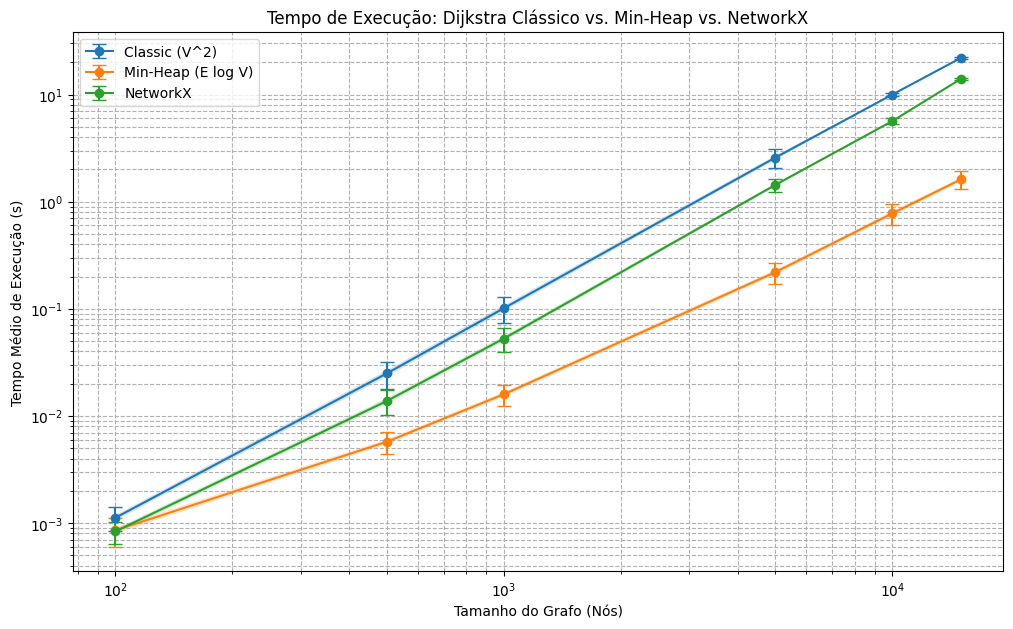

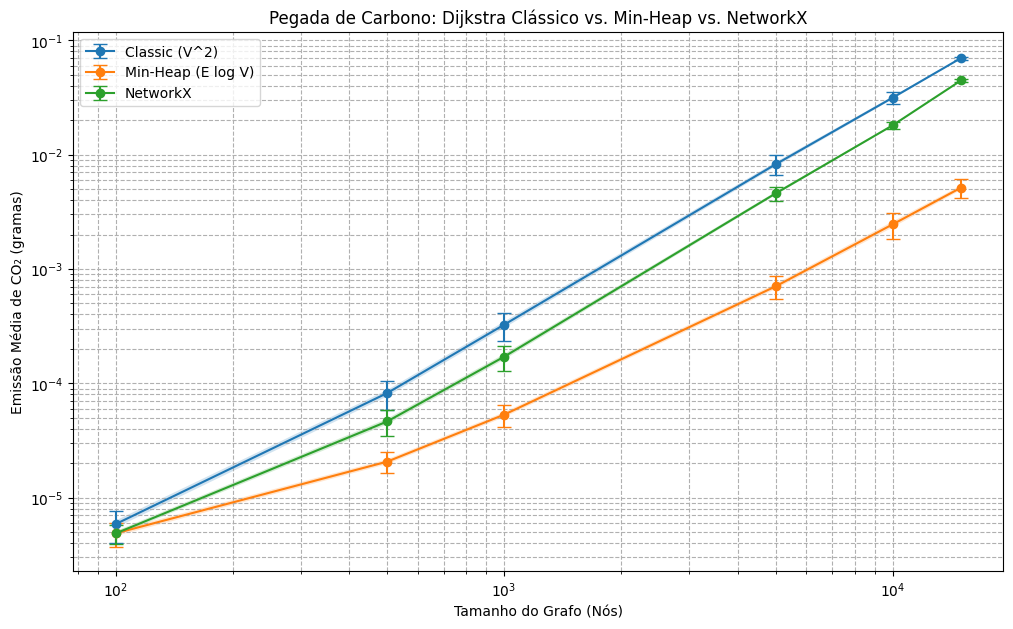

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# 1. Carregar o CSV parcial com os resultados brutos
df_results = pd.read_csv("dijkstra_benchmark_partial.csv")

# 2. Calcular médias, desvios e intervalos de confiança
def mean_ci(series, confidence=0.95):
    mean = series.mean()
    sem = st.sem(series)
    n = len(series)
    h = sem * st.t.ppf((1 + confidence) / 2., n-1) if n > 1 else 0
    return pd.Series({"mean": mean, "std": series.std(), "ci_low": mean - h, "ci_high": mean + h})

df_agg_time = df_results.groupby(['algoritmo','size'])['time_sec'].apply(mean_ci).unstack()
df_agg_co2  = df_results.groupby(['algoritmo','size'])['co2_grams'].apply(mean_ci).unstack()

# Juntar em um único DataFrame
df_agg = pd.concat([
    df_agg_time.add_prefix("time_"),
    df_agg_co2.add_prefix("co2_")
], axis=1).reset_index()

df_agg.to_csv("dijkstra_benchmark_summary.csv", index=False)
print(df_agg.head())

# 3. Gráfico de tempo
plt.figure(figsize=(12,7))
for alg in df_agg['algoritmo'].unique():
    df_alg = df_agg[df_agg['algoritmo']==alg]
    plt.errorbar(
        df_alg['size'], df_alg['time_mean'],
        yerr=df_alg['time_std'], # barras de erro = desvio padrão
        label=alg, fmt='-o', capsize=5
    )
    # opcional: sombrear intervalo de confiança
    plt.fill_between(df_alg['size'], df_alg['time_ci_low'], df_alg['time_ci_high'], alpha=0.2)

plt.xlabel("Tamanho do Grafo (Nós)")
plt.ylabel("Tempo Médio de Execução (s)")
plt.title("Tempo de Execução: Dijkstra Clássico vs. Min-Heap vs. NetworkX")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.yscale('log'); plt.xscale('log')
plt.savefig("benchmark_tempo.png")
plt.show()

# 4. Gráfico de CO₂
plt.figure(figsize=(12,7))
for alg in df_agg['algoritmo'].unique():
    df_alg = df_agg[df_agg['algoritmo']==alg]
    plt.errorbar(
        df_alg['size'], df_alg['co2_mean'],
        yerr=df_alg['co2_std'],
        label=alg, fmt='-o', capsize=5
    )
    plt.fill_between(df_alg['size'], df_alg['co2_ci_low'], df_alg['co2_ci_high'], alpha=0.2)

plt.xlabel("Tamanho do Grafo (Nós)")
plt.ylabel("Emissão Média de CO₂ (gramas)")
plt.title("Pegada de Carbono: Dijkstra Clássico vs. Min-Heap vs. NetworkX")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.yscale('log'); plt.xscale('log')
plt.savefig("benchmark_co2.png")
plt.show()
